# Emotions Recognition

Udacity Nanodegre Capstone Project

## Basic Data Research

First of all, let's look into available data structure and sample some examples.

In [1]:
from IPython.display import display
from basedir import data
import pandas as pd


emotions_data = pd.read_csv(data('fer2013', 'fer2013.csv'))
emotions_data['emotion'] = emotions_data['emotion'].apply(int)
emotions_data.head(3)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training


In [3]:
def get_subset(labels):
    if isinstance(labels, str):
        labels = [labels]
    return pd.DataFrame(emotions_data[emotions_data.Usage.isin(labels)])


training_data = get_subset(['Training', 'PublicTest'])
del training_data['Usage']

test_data = get_subset('PrivateTest')
del test_data['Usage']

In [10]:
%matplotlib inline
from itertools import chain
import random

import matplotlib.pylab as plt
import numpy as np


verbose_emotion = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


def to_image(data, size=48):
    if isinstance(data, str):
        data = data.split()
    flat = np.array([float(px) for px in data])
    return flat.reshape((size, size))


def sample_emotions(emotions=None):
    grid_spec = {'hspace': 0.5}
    fig, axes = plt.subplots(4, 4, figsize=(8, 8), facecolor='whitesmoke', gridspec_kw=grid_spec)
    df = training_data
    n = len(df)

    if emotions is not None:
        emotions = list(
            i for i, name in enumerate(verbose_emotion)
            if name.lower() in emotions)
        df = df[df.emotion.isin(emotions)]

    # color_map = plt.cm.get_cmap('Greys')
    color_map = plt.cm.get_cmap('coolwarm')

    for ax in chain(*axes):
        record = df.iloc[random.randint(0, n)]
        img = to_image(record.pixels)
        ax.imshow(img, cmap=color_map)
        ax.set_title("Emotion = '%s'" % verbose_emotion[record.emotion],
                     fontdict={'fontsize': 10})
        ax.set_xticks([])
        ax.set_yticks([])
        
    fig.savefig("/Users/ck/Desktop/faces.png", format='png')


sample_emotions()

In [24]:
from collections import Counter
from operator import itemgetter

counter = Counter(emotions_data.emotion.tolist())
pairs = sorted(counter.items(), key=itemgetter(0))
verbose = [{"label": i, "verbose": verbose_emotion[i], "count": count}  
           for i, count in pairs]

df = pd.DataFrame(verbose)
print("Emotions set")
display(df)

Emotions set


,count,label,verbose
0,4953,0,Angry
1,547,1,Disgust
2,5121,2,Fear
3,8989,3,Happy
4,6077,4,Sad
5,4002,5,Surprise
6,6198,6,Neutral


## More Involved Analysis and Data Transformation

First steps worked with original data file and don't alternate it in any way. To make the original data more suitable for next steps, a few modifications were applied.

Also, as soon as the dataset was excluded from repository (because of its big size), an extra utility was created to download this data. Thereofore, the first step is to download, preapre and dump processed data to make it available for next steps. Global configuration and misc parameters are also set in the next cell.

In [2]:
import os
import glob
import logging
import logging.config

import numpy as np
import pandas as pd
from IPython.display import display

from basedir import DATA_FOLDER, data
from emotions import Dataset, dump, load
from utils import sample_images, plot_learning_curve


# Notebook configuration. Next cells could use these values to contol code flow 
DEBUG = True
LOGGING_CONFIG = {
    'version': 1,
    'disable_existing_loggers': True,
    'formatters': {
        'console': {
            'format': '[%(asctime)s] %(name)s: %(message)s'            
        }
    },
    'handlers': {
        'stream': {
            'level': 'DEBUG',
            'formatter': 'console',
            'class': 'logging.StreamHandler',
        }
    },
    'loggers': {
        'notebook': {
            'handlers': ['stream'],
            'level': logging.DEBUG if DEBUG else logging.INFO,
            'propagate': False            
        }
    }
}
RANDOM_STATE = 1
SUBSET_INDEX = 0 if DEBUG else None
N_FOLDS = 10

# Data configuration
IMAGE_SIZE = 48
FALLBACK_VALUE = DATA_FOLDER
DATA_FOLDER = os.environ.get('DATA_FOLDER', FALLBACK_VALUE)
assert DATA_FOLDER, "DATA_FOLDER env variable is not set. Set variable or provide fallback value"

# Setup logging
logging.config.dictConfig(LOGGING_CONFIG)
log = logging.getLogger('notebook')

In [1]:
filenames = list(glob.glob1(DATA_FOLDER, '*.npy'))
loader = Dataset('fer2013', dataset_folder=DATA_FOLDER)

if not filenames:
    log.info("Data files not found. Loading dataset..")
    url = 'https://www.dropbox.com/s/jrivrub0ii16s4h/fer2013.tar.gz?dl=1'
    loader.load_from_url(url, archive=True, name_in_archive='fer2013/fer2013.csv')

    log.info("Preparing dataset for processing..")
    loader.prepare()
    df = loader.prepared
    X = df.drop(['label', 'verbose', 'subset'], axis=1).values
    y = df.label.values
    split_config = {'shuffle': True, 'random_state': RANDOM_STATE}

    log.info("Dump dataset into smaller chunks..")

    # save data splitted into chunks
    dump(X, y, prefix='emotions', output_dir=DATA_FOLDER, folds=N_FOLDS, stratified=True, **split_config)
    filenames = list(glob.glob1(DATA_FOLDER, '*.npy'))
    assert len(filenames) > 0, "Data loader invoked, but data not found"

    log.info("File created in %s:", DATA_FOLDER)
    for filename in filenames:
        log.info(".. %s", filename)
    log.info("Done!")
            

if DEBUG:
    log.warning("You're in DEBUG mode - only a subset of data will be used")

X, y = load(DATA_FOLDER, prefix='emotions', subset_index=SUBSET_INDEX)
log.info("Dataset shape: X=%s, y=%s" % (str(X.shape), str(y.shape)))  
log.info("Images sample to verify that dataset wasn't malformed")
fig, _ = sample_images(X, img_size=IMAGE_SIZE)
display(fig)

NameError: name 'glob' is not defined

Next step is data normalization and splitting into test and train subsets. 

> **Note**: Dependting on applied model, extra preprocessing steps could be applied (like reformating images into squeare matrices before applyied CNN, feature selection for linear models, etc.)

[2017-01-10 08:18:13,917] notebook: Images sample after Min-Max normalization


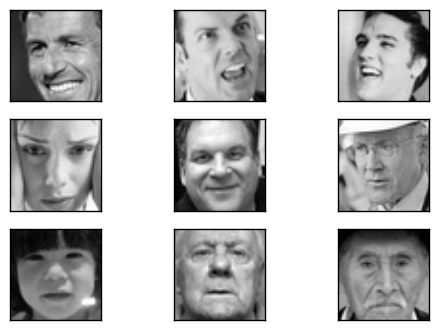

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y, random_state=RANDOM_STATE, test_size=0.1)

log.info("Images sample after Min-Max normalization")
fig, _ = sample_images(X_train, img_size=IMAGE_SIZE)
display(fig)

---
### Baseline models

To have a basic threshold to estimate deep learning model performence, the following baseline estimators were chosen:
1. Multiclass Logistic Regression (one-vs-all approach)
2. Random Forest Classifier

### Logistic regression

The first applyied model is Logistic Regression Classifier. To select the most optimal model, grid search is applied. The varying parameters are `penalty` (regularization norm) and `C` (reqularization multiplier, i.e. $\frac{1}_{\lambda}$).

In [11]:
from operator import itemgetter

from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV


param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [100.0, 30.0, 10.0, 3.0, 1.0]
}

logreg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)        
log.info("Selected baseline model: %s", str(logreg.__class__.__name__))
grid_search = GridSearchCV(estimator=logreg, cv=5, param_grid=param_grid, n_jobs=-1, verbose=2)
_ = grid_search.fit(X_train, y_train.ravel())

[2017-01-09 13:17:19,730] notebook: Selected baseline model: LogisticRegression


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=100.0, penalty=l1 .............................................
[CV] C=100.0, penalty=l1 .............................................
[CV] C=100.0, penalty=l1 .............................................
[CV] C=100.0, penalty=l1 .............................................
[CV] C=100.0, penalty=l1 .............................................
[CV] C=100.0, penalty=l2 .............................................
[CV] C=100.0, penalty=l2 .............................................
[CV] C=100.0, penalty=l2 .............................................
[CV] .............................. C=100.0, penalty=l2, total= 2.1min
[CV] C=100.0, penalty=l2 .............................................
[CV] .............................. C=100.0, penalty=l2, total= 2.1min
[CV] C=100.0, penalty=l2 .............................................
[CV] .............................. C=100.0, penalty=l2, total= 2.1min
[CV] C=30.0, pen

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 11.9min


[CV] ............................... C=10.0, penalty=l2, total= 1.5min
[CV] C=3.0, penalty=l1 ...............................................
[CV] ............................... C=10.0, penalty=l1, total= 4.1min
[CV] C=3.0, penalty=l1 ...............................................
[CV] ............................... C=10.0, penalty=l2, total= 1.6min
[CV] C=3.0, penalty=l2 ...............................................
[CV] ............................... C=10.0, penalty=l1, total= 4.1min
[CV] C=3.0, penalty=l2 ...............................................
[CV] ................................ C=3.0, penalty=l1, total= 1.9min
[CV] C=3.0, penalty=l2 ...............................................
[CV] ................................ C=3.0, penalty=l1, total= 1.8min
[CV] C=3.0, penalty=l2 ...............................................
[CV] ............................... C=10.0, penalty=l1, total= 4.4min
[CV] C=3.0, penalty=l2 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 15.5min finished


Next cell shows validation results along with the best parameters.

In [12]:
best_logreg = grid_search.best_estimator_
best_logreg_params = grid_search.best_params_
logreg_cv_results = grid_search.cv_results_
param_cols = [c for c in logreg_cv_results.keys()
              if c.startswith('param_')]

columns_of_interest = [
    'mean_fit_time', 
    'mean_train_score', 'std_train_score',
    'mean_test_score', 'std_test_score']
columns_of_interest.extend(param_cols)

df_cv_results = pd.DataFrame(logreg_cv_results)[columns_of_interest]
display(df_cv_results)
log.debug("Best parameters: %s", best_logreg_params)

,mean_fit_time,mean_train_score,std_train_score,mean_test_score,std_test_score,param_C,param_penalty
0,318.740509,0.998994,0.000395,0.260520,0.018001,100,l1
1,129.808681,0.998917,0.000451,0.267327,0.018008,100,l2
2,316.145396,0.998762,0.000569,0.263923,0.021088,30,l1
3,108.876100,0.998376,0.000568,0.272896,0.019248,30,l2
4,252.224634,0.998066,0.000489,0.267946,0.018439,10,l1
5,89.270654,0.995513,0.000998,0.280012,0.026848,10,l2
6,113.183278,0.945621,0.002716,0.291151,0.022905,3,l1
7,65.504585,0.962792,0.002686,0.293317,0.021630,3,l2
8,24.686762,0.724011,0.004359,0.328589,0.026835,1,l1
9,39.991768,0.888689,0.002874,0.315285,0.029461,1,l2


[2017-01-09 13:33:08,242] notebook: Best parameters: {'C': 1.0, 'penalty': 'l1'}


It could be noted right from validation results that mean test score is quite low for selected classifier parameters. That is quite different from results that *Logistic Regression* could show when applied to some other, more simple datasets. Probably it happens because humans face emotions could be difficult to distinguish from each other.
 
Nevertherless, let's plot learning curve too see if more amount data helps to improve. As it was mentioned earlier, only small amount of data is used on first run. So now let's take more data and also plot a training curve and calculate classification metrics that could give some insights about baseline model quality and give validation threshold for more sophisticated models.

[2017-01-10 08:37:48,466] notebook: X shape = (7183, 2304), y shape = (7183,)


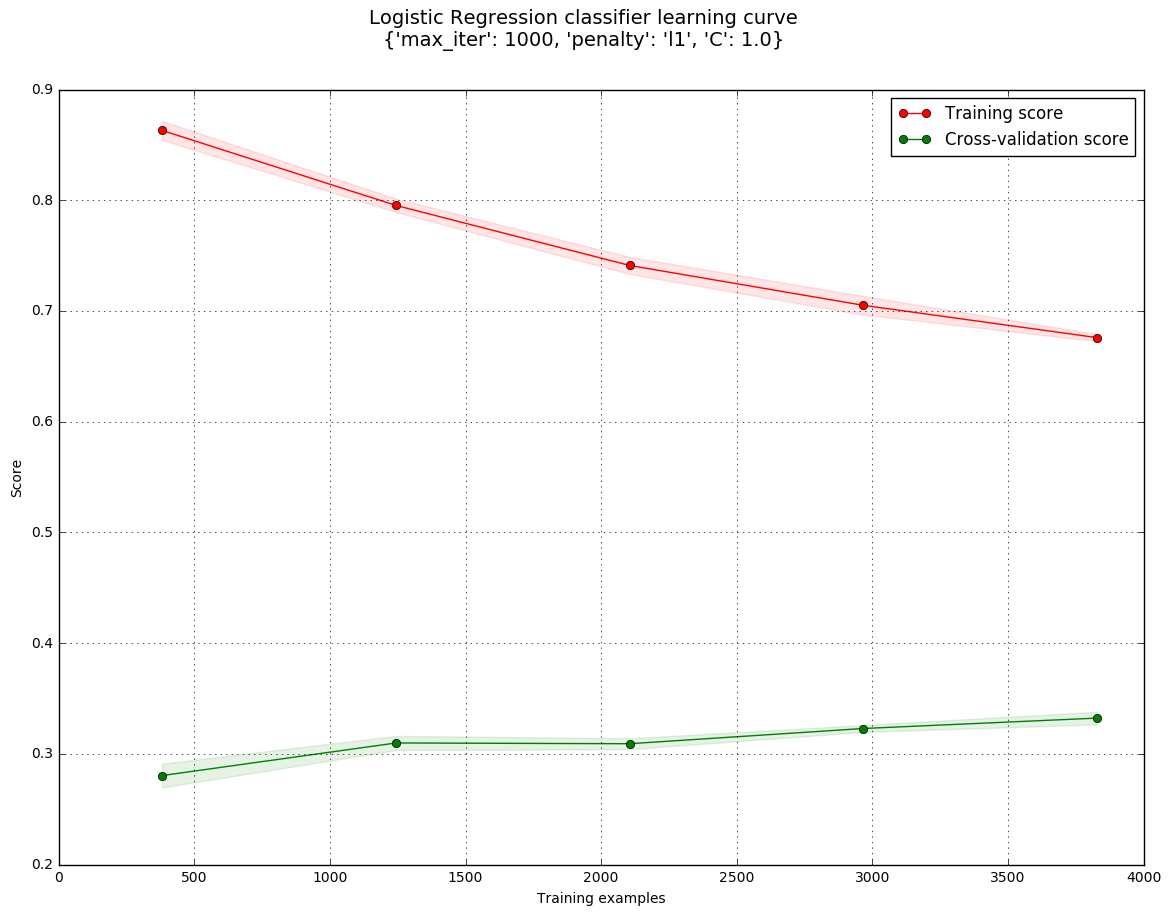

             precision    recall  f1-score   support

      Angry       0.23      0.18      0.20       187
    Disgust       0.00      0.00      0.00        18
       Fear       0.18      0.13      0.15       207
      Happy       0.40      0.58      0.47       350
        Sad       0.27      0.25      0.26       251
   Surprise       0.44      0.41      0.43       157
    Neutral       0.28      0.25      0.27       267

avg / total       0.30      0.32      0.30      1437



In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

from utils import plot_learning_curve
from emotions import load


X_chunk0, y_chunk0 = load(DATA_FOLDER, 'emotions', subset_index=0)
X_chunk1, y_chunk1 = load(DATA_FOLDER, 'emotions', subset_index=1)
X_more, y_more = np.r_[X_chunk0, X_chunk1], np.r_[y_chunk0, y_chunk1]

log.info('X shape = %s, y shape = %s', X_more.shape, y_more.shape)

X_more_train, X_more_test, y_more_train, y_more_test = train_test_split(
    MinMaxScaler().fit_transform(X_more), y_more, random_state=RANDOM_STATE, test_size=0.2)

best_logreg_params = {'C': 1.0, 'penalty': 'l1', 'max_iter': 1000}
best_model = LogisticRegression(random_state=RANDOM_STATE)
best_model.set_params(**best_logreg_params)
title = 'Logistic Regression classifier learning curve\n%s' % best_logreg_params
fig = plot_learning_curve(best_model, title, X_more_train, y_more_train)
display(fig)

best_model.fit(X_more_train, y_more_train)
y_preds = best_model.predict(X_more_test)
report = classification_report(y_more_test, y_preds, target_names=loader.VERBOSE_EMOTION)
print(report)

Data size increasing has some effect on estimator's accuracy, but not too big. Also note that as it was earlier mentioned, dataset is unbalanced and some facial emotions are underrepresented. For example, `Disgust` labels are much more rare then `Happy` or `Neutral`.

In [3]:
# Restore the whole dataset from chunks
import glob

n_total = len(list(glob.glob1(DATA_FOLDER, '*.npy'))) // 2
Xs, ys = zip(*[load(DATA_FOLDER, 'emotions', subset_index=i) for i in range(n_total)])             
X, y = np.r_[Xs], np.r_[ys]        
log.info('X shape = %s, y shape = %s', X.shape, y.shape)

[2017-01-11 04:32:33,574] notebook: X shape = (35887, 2304), y shape = (35887,)


In [4]:
# Apply logistic regression to this data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib

from utils import Timer, save_model


X_train, X_test, y_train, y_test = train_test_split(
    MinMaxScaler().fit_transform(X), y, random_state=RANDOM_STATE, test_size=0.1)

full_model = LogisticRegression(C=1.0, penalty='l1', max_iter=1000, random_state=RANDOM_STATE, n_jobs=-1)
log.info('Fitting model using full dataset..')
with Timer() as timer:
    full_model.fit(X_train, y_train)
save_model(full_model, DATA_FOLDER, 'logreg.model')
log.info("Time elapsed to fit model: %s", timer)

[2017-01-11 04:32:35,882] notebook: Fitting model using full dataset..
[2017-01-11 04:49:02,188] notebook: Time elapsed to fit model: 00:16:26


In [8]:
from itertools import chain

from sklearn.metrics import classification_report, roc_curve
import matplotlib.pyplot as plt

from utils import load_model
from emotions import FER2013Dataset


target_names = FER2013Dataset.VERBOSE_EMOTION
full_model = load_model(DATA_FOLDER, 'logreg.model')
y_preds = full_model.predict(X_test)
print(classification_report(y_test, y_preds, target_names=target_names))

roc_curves, axes = plt.subplots(4, 2, figsize=(14, 10))
for target_name, ax in zip(target_names, chain(*axes)):
    

             precision    recall  f1-score   support

      Angry       0.27      0.17      0.21       475
    Disgust       0.40      0.08      0.13        51
       Fear       0.29      0.16      0.21       548
      Happy       0.43      0.66      0.52       894
        Sad       0.28      0.27      0.27       600
   Surprise       0.43      0.45      0.44       384
    Neutral       0.33      0.33      0.33       637

avg / total       0.35      0.36      0.34      3589

Help on function roc_curve in module sklearn.metrics.ranking:

roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)
    Compute Receiver operating characteristic (ROC)
    
    Note: this implementation is restricted to the binary classification task.
    
    Read more in the :ref:`User Guide <roc_metrics>`.
    
    Parameters
    ----------
    
    y_true : array, shape = [n_samples]
        True binary labels in range {0, 1} or {-1, 1}.  If labels are not
        binary, pos_l

### Random Forest

The second baseline model is a Random Forest classifier. One advantage of ensemble models is that these methods allows to combine together a bunch of _weak learners_ - predictors, which if applied standalone show low prediction accuracy, but when combined together and have enough data could show good results.

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_split': [2, 3, 4]
}

random_forest = RandomForestClassifier()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator 

# datagen = ImageDataGenerator(featurewise_center=True,
#                              featurewise_std_normalization=True,
#                              zca_whitening=True)
# n, m = sample_grid = (3, 3)
# fig, axes = plt.subplots(n, m, figsize=(10, 10))

# for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=n * m):    
    
#     for ax, pixels, label in zip(chain(*axes), X_batch, y_batch):
#         image = pixels.reshape(28, 28)
#         ax.imshow(cmap=plt.get_cmap('gray'))
#         ax.set_title("Emotion = '%s'" % verbose_emotion[label], fontdict={'fontsize': 10})
#         ax.set_xticks([])
#         ax.set_yticks([])
#         break

